In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from helper import *
import const
from sim import Sim
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.integrate import trapz as integrate
from scipy.integrate import cumtrapz as cumintegrate


In [8]:
time = 1*const.day


In [9]:
rproc = 'strong'

data_rproc = np.load(os.path.join('..', 'rprocess', '%s.npz' % rproc), allow_pickle=True)
data_rproc = SimpleNamespace(**data_rproc)
idx_rproc = np.searchsorted(data_rproc.time, time)
Zmax = 118

if time < data_rproc.time[0]:  print('Warning: time below minimum time in KNe simulations')
if time > data_rproc.time[-1]: print('Warning: time above maximum time in KNe simulations')


In [10]:
Nmax = np.max(data_rproc.ab_iso[idx_rproc])[0][0]
ab_grid = np.zeros((Nmax, Zmax))

for Z in range(Zmax+1):

    A_list, ab_list = data_rproc.ab_iso[idx_rproc, Z]
    for A, ab in zip(A_list, ab_list): ab_grid[A-Z, Z] = ab


In [11]:
with open(os.path.join('..', 'NuDat', 'nndc.csv'), 'r') as f: lines = f.readlines()    
stab_grid = np.full((178, 119), False)
for line in lines[1:]:
    line_split = line.split(',')
    if line_split[4] == 'STABLE': 
        Z = int(line_split[0])
        N = int(line_split[1])
        stab_grid[N, Z] = True


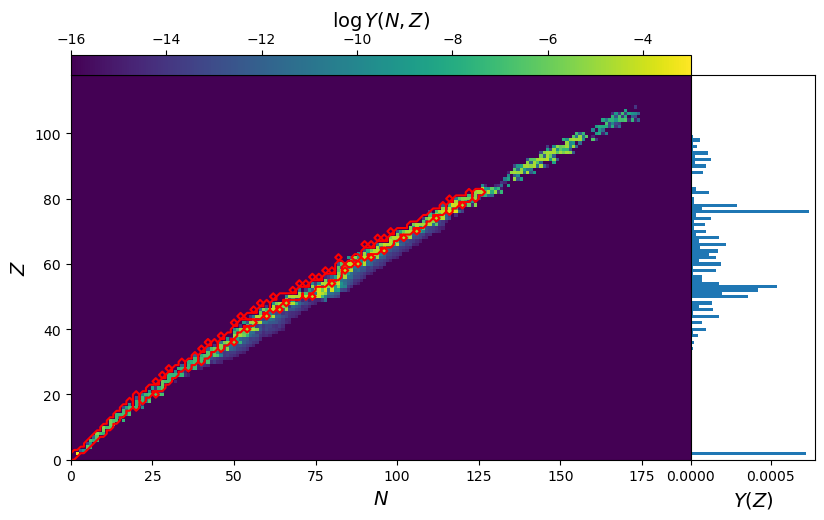

In [12]:
fig, ax1 = plt.subplots(figsize=(8, 8))

im = ax1.imshow(np.log10(ab_grid+1e-20).T, origin='lower', vmin=-16, vmax=-3)

ax1.contour(np.arange(178), np.arange(119), stab_grid.T, colors='red', levels=[0, 1])

ax1.set_xlim(0, 190)
ax1.set_ylim(0, 118)

ax1.set_xlabel(r'$N$', fontsize=14)
ax1.set_ylabel(r'$Z$', fontsize=14)

ax2 = ax1.inset_axes([1, 0, 0.2, 1])
ax2.sharey(ax1)
ax2.barh(np.arange(Zmax+1), data_rproc.ab_elem[idx_rproc], height=1.0, align='center')

ax2.get_yaxis().set_visible(False)
ax2.set_xlabel(r'$Y(Z)$', fontsize=14)

cax = ax1.inset_axes([0, 1, 1, 0.05])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'$\log Y(N, Z)$', fontsize=14)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')


In [13]:
run = 1

data_KNe = np.load(os.path.join('..', 'KNexplosions', 'runhr%d.npz' % run))
data_KNe = SimpleNamespace(**data_KNe)
idx_KNe = np.searchsorted(data_KNe.time, time)

if time < data_KNe.time[0]:  print('Warning: time below minimum time in KNe simulations')
if time > data_KNe.time[-1]: print('Warning: time above maximum time in KNe simulations')

rho = data_KNe.rho_shock[idx_KNe]
temp = data_KNe.temp_shock[idx_KNe]
    
print('Mej: %.3g Msol' % (data_KNe.Mej/const.M_sol))
print('vej: %.3g km/s' % (data_KNe.vej/const.km))
print('n_cgs: %.3g/cc' % (data_KNe.nH_cgm))
print('rho: %.3g g/cc' % rho)
print('T: %.3g K' % temp)
    

Mej: 0.01 Msol
vej: 1.5e+04 km/s
n_cgs: 10/cc
rho: 8.55e-13 g/cc
T: 4.23e+04 K


In [ ]:
sim = Sim(ener=1000000, rho=rho, do_iso=False)

for Z in [52, 92]:#range(1, 99):
    
    ab = data_rproc.ab_elem[idx_rproc, Z]
    if ab > 0:
        A_avg = data_rproc.A_avg[idx_rproc, Z]
        sim.add_spec(Z=Z, A=A_avg, ab=ab)

#sim.add_Bturb(Bturb=1e4, q=5/3, fturb=1.0, Lmax=1e17)
#sim.add_Bco(Bmag=1e2, Bhat=np.array([0, 1, 0]), method=2)
        

/Users/za9132/Documents/research/Chris/thunderstorm/sim.py:158: RuntimeWarning: divide by zero encountered in log
  sig_func = interp1d(np.log(ener), np.log(sig), fill_value='extrapolate')


In [51]:
sim.reset()
for i in range(1000):
    sim.step()


Text(0.5, 1.0, '$t=0.38~{\\rm s}$')

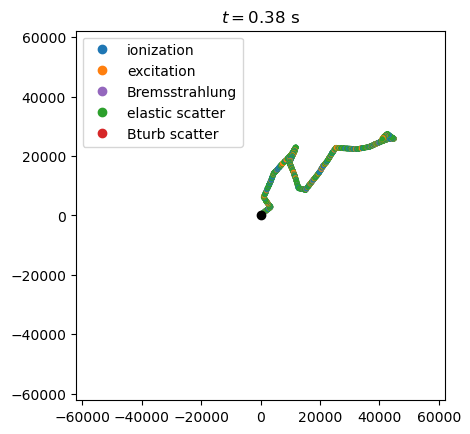

In [53]:
evcat2num = {
    'ionization': 0,
    'excitation': 1,
    'Bremsstrahlung': 4,
    'elastic scatter': 2,
    'Bturb scatter': 3
}

x_list, y_list = np.array(sim.coord_list)[:, X], np.array(sim.coord_list)[:, Y]
color_list = ['C%d'%evcat2num[sim.event_list[idx].cat] for idx in sim.idx_event_list]

plt.plot(0, 0, color='black', marker='o')
plt.scatter(x_list/const.km, y_list/const.km, marker='.', c=color_list)
plt.plot(x_list/const.km, y_list/const.km, color='black', zorder=-1)

rmax = np.max(np.sqrt(x_list**2+y_list**2))/const.km
plt.xlim(-1.2*rmax, 1.2*rmax)
plt.ylim(-1.2*rmax, 1.2*rmax)

plt.gca().set_aspect(True)

cust_lines = [Line2D([0], [0], marker='o', linestyle='', color='C%d'%num, label=label) for (label, num) in evcat2num.items()]
plt.legend(handles=cust_lines)

plt.title(r'$t=%.2f~{\rm s}$'%sim.time)


Text(0, 0.5, 'number of interactions')

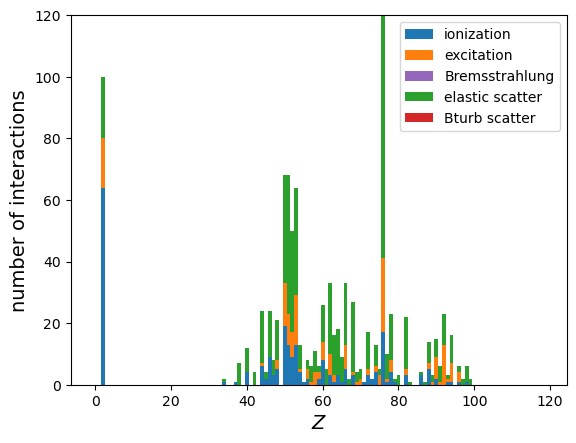

In [54]:
ncat = 5
ev_hist = np.zeros((ncat, Zmax+1), dtype=int)

for idx in sim.idx_event_list:
    ev_hist[evcat2num[sim.event_list[idx].cat], sim.event_list[idx].spec] += 1
    
for i in range(ncat):
    ev_hist_cum = np.sum(ev_hist[:i], axis=0)
    plt.bar(np.arange(Zmax+1), ev_hist[i], width=1, bottom=ev_hist_cum);
    
cust_lines = [Patch(facecolor='C%d'%num, label=label) for (label, num) in evcat2num.items()]
plt.legend(handles=cust_lines)

plt.xlabel(r'$Z$', fontsize=14)
plt.ylabel(r'number of interactions', fontsize=14)


In [55]:
for idx in sim.idx_event_list:
    print(sim.event_list[idx].label)

Sb excitation
Ba ionization
He excitation
Dy excitation
I ionization
Os large angle elastic scatter
He ionization
Pt large angle elastic scatter
U large angle elastic scatter
Re excitation
He excitation
Os ionization
Rh large angle elastic scatter
He ionization
Eu ionization
Os excitation
I large angle elastic scatter
Hg large angle elastic scatter
Nd excitation
He ionization
Sn large angle elastic scatter
Er large angle elastic scatter
Xe large angle elastic scatter
Au ionization
He ionization
Te large angle elastic scatter
Cf ionization
Pt large angle elastic scatter
Gd large angle elastic scatter
Er large angle elastic scatter
Dy large angle elastic scatter
Ra excitation
Sn ionization
Rb ionization
He excitation
Gd large angle elastic scatter
Sb large angle elastic scatter
Os large angle elastic scatter
Pb large angle elastic scatter
Sn ionization
Dy excitation
Os large angle elastic scatter
Sr large angle elastic scatter
Os large angle elastic scatter
Er large angle elastic scatter